# Model AGB from ATL08 height; show on boreal polar map  
Paul Montesano, March 2023


In [1]:
library(aws.s3)
library(rgdal)
library(raster)
library(tidyverse)
library(dplyr)
library(grid)
library(gridExtra)
library(RColorBrewer)
library(data.table)

library(fs)
library(sf)
library(rgdal)


library(rgeos)
library(mapproj)
#library(rgee)
library(viridis)
library(wesanderson)
library(scales)
library(tools)
library(patchwork)

library(rnaturalearth)
library(rnaturalearthdata)
library(feather)
library(tools)
library(rockchalk)

Warning message:
“package ‘aws.s3’ was built under R version 4.1.3”
Loading required package: sp

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.3.2, released 2021/09/01
Path to GDAL shared files: /opt/conda/envs/r-with-gdal/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.0.1, March 5th, 2021, [PJ_VERSION: 801]
Path to PROJ shared files: /opt/conda/envs/r-with-gdal/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr  

## Set output figure dir.

In [2]:
OUT_FIGURE_DIR = '/projects/my-public-bucket/boreal_polar_map/paper_figs'

In [3]:
GEDI2AT08AGB_v2 <- function(rds_models, models_id, in_data, offset=100, 
                            COLS_LIST= c("lon","lat","RH_25","RH_50","RH_60","RH_70","RH_75","RH_80","RH_90","RH_95","RH_98"), 
                            EXCLUDE_LC_VALUE_LIST = c(0, 60, 80, 200, 50, 70), # Updated with copernicus LC values for which we want to assign AGB values of 0 
                            DO_MASK=FALSE, 
                            RESAMP_COVAR_MAT=TRUE, 
                            RESAMP_ITER=50
                           ){
    #'''
    # Function to compute mean AGB and SE from ICESat-2 ATL08 observations of vegetation height.
    # Uses the GEDI-developed allometric equations (2 parameters of RH values)
    #'''
    
    # rds_models
    names(rds_models)<-models_id

    #if(DO_MASK){
    #    in_data = in_data %>% dplyr::filter(slopemask ==1 & ValidMask == 1)
    #}
    xtable_i<-na.omit(as.data.frame(in_data))
    names(xtable_i)[1:length(COLS_LIST)]<-COLS_LIST  # PMM names(xtable_i)[1:11]<-COLS_LIST

    # Adjust for offset in model fits (100)
    # GEDI L4A team added offset to all the height metrics so they would never be negative)
    #xtable_sqrt<-xtable_i[3:10]+offset
    xtable_sqrt <- xtable_i %>% dplyr::select(contains("RH")) + offset # PMM 

    # get unique ids
    # apply models by id
    xtable_sqrt$AGB<-NA
    xtable_sqrt$SE<-NA
    
    # Assign model id based on landcover

    # if using ground photon models: 1 = DBT trees (boreal-wide), 2=Evergreen needleleaf trees (boreal-wide), 12 = boreal-wide all PFT
    # if using no ground photon models: 1 = DBT trees (boreal-wide), 3=Evergreen needleleaf trees (boreal-wide), 8 = boreal-wide all PFT

    # for the seg_landcov: {0: "water", 1: "evergreen needleleaf forest", 2: "evergreen broadleaf forest", \ 3: "deciduous needleleaf forest", 4: "deciduous broadleaf forest", \ 5: "mixed forest", 6: "closed shrublands", 7: "open shrublands", \ 8: "woody savannas", 9: "savannas", 10: "grasslands", 11: "permanent wetlands", \ 12: "croplands", 13: "urban-built", 14: "croplands-natural mosaic", \ 15: "permanent snow-ice", 16: "barren"})
    
    # for the seg_landcov update w v5 to Copernicus: 
    # {0: "NA", 111, 121: "evergreen needleleaf forest", 112, 122: "evergreen broadleaf forest", \ 
    # 113, 123: "deciduous needleleaf forest", 114, 124: "deciduous broadleaf forest", \ 
    # 115, 125: "mixed forest", 116, 126:"closed forest unknown", 20: "shrublands", 30: "herbaceous vegetation", \ 
    # 100: "moss and lichen", 60: "bare/sparse", 80, 200: "water", 40: "agriculture", 50: "urban-built", 70: "permanent snow-ice"})

    xtable_sqrt$model_id <- 'NA'
    xtable_sqrt$model_id[xtable_i$seg_landcov==111] <- 'm3'
    xtable_sqrt$model_id[xtable_i$seg_landcov==121] <- 'm3'
    xtable_sqrt$model_id[xtable_i$seg_landcov==112] <- 'm1'
    xtable_sqrt$model_id[xtable_i$seg_landcov==122] <- 'm1'
    xtable_sqrt$model_id[xtable_i$seg_landcov==113] <- 'm3'
    xtable_sqrt$model_id[xtable_i$seg_landcov==123] <- 'm3'
    xtable_sqrt$model_id[xtable_i$seg_landcov==114] <- 'm1'
    xtable_sqrt$model_id[xtable_i$seg_landcov==124] <- 'm1'
    xtable_sqrt$model_id[xtable_sqrt$model_id=='NA'] <- 'm8'

    #xtable_sqrt$model_id<-names(rds_models)[1]
    ids <- unique(xtable_sqrt$model_id)
    
    print(ids)
    n_models <- length(ids)
    
    # One model for actual application - no resampling
    
    # Iterate through re-sampling models
    for (i in ids){
    
        # subset data for model id
        #print(rds_models[names(rds_models)==i])
        model_i<-readRDS(rds_models[names(rds_models)==i])

        # get variance covariance matrix
        model_varcov <- vcov(model_i)

        # get coefficients
        coeffs <- model_i$coefficients
        #print(model_i$coefficients)
        # Modify coeffients through sampling variance covariance matrix
        if(RESAMP_COVAR_MAT){
              mod.coeffs <- mvrnorm(n = RESAMP_ITER, mu=coeffs, Sigma = model_varcov)
              model_i$coefficients <- mod.coeffs[1,]
            
        }

        # SE
        xtable_sqrt$SE[xtable_sqrt$model_id==i] <- summary(model_i)$sigma^2

        # AGB prediction
        xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-predict(model_i, newdata=xtable_sqrt[xtable_sqrt$model_id==i,])

        # define C
        C <- mean(model_i$fitted.values^2)/mean(model_i$model$`sqrt(AGBD)`^2)

        # Set negatives to zero
        negs <- which(xtable_sqrt$AGB<0)
        if(length(negs)>0){
            xtable_sqrt$AGB[negs] == 0.0
        }

        # We multiply by C in case there is a systematic over or under estimation in the model (bias correction)
        xtable_sqrt$AGB[xtable_sqrt$model_id==i]<-C*(xtable_sqrt$AGB[xtable_sqrt$model_id==i]^2)

        # Set predictions where slopemask & validmask are 0 to 0
        xtable_sqrt$AGB[which(xtable_sqrt$slopemask==0)] <- 0.0

        xtable_sqrt$AGB[which(xtable_sqrt$ValidMask==0)] <- 0.0

        # Set predictions where landcover is water, urban, snow, barren to 0
        #bad_lc <- c(0, 13, 15, 16)
        xtable_sqrt$AGB[which(xtable_sqrt$seg_landcov %in% EXCLUDE_LC_VALUE_LIST)] <- 0.0

    }
    
    xtable2<-cbind(xtable_i, xtable_sqrt$model_id, xtable_sqrt$AGB, xtable_sqrt$SE)
    ncol <- ncol(xtable2)
    
    # Returning AGB mean and standard error in megagrams per hectare
    colnames(xtable2)[(ncol-2):ncol]<-c('AGB_model_id','AGB_mean_mg_ha', 'AGB_se_mg_ha')
    
    return(xtable2)
}

# Circ map new: trying to combine the best of the sf and sp approaches
DO_MAP_BOREAL_SP <- function( MAP_EXTENT = extent(-180,180,45,90), xlim=NULL, ylim=NULL, rotate_map=0, proj_name = 'azequalarea', LAYER_LIST=NULL, 
                             boreal_shp_fn = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'){
  #
  # Map with a polar projection
  #
  
  # Color scale help
  #https://biostats.w.uib.no/color-scale-for-continuous-variables/
  
  #source(path("C:\\Users\\pmontesa\\Google Drive\\Work\\R","plot_functions.R"))
  # Shapefiles
  
  world <- crop(ne_countries(scale = "medium", returnclass = "sp"), MAP_EXTENT)
  
  # WWF
  #boreal <- shp_fort_join("D:\\databank\\wwf\\arc\\wwf_circumboreal_Dissolve.shp", MAP_EXTENT, REPROJECT = TRUE)
  # TerraPulse
  boreal <- shp_fort_join(boreal_shp_fn, MAP_EXTENT, REPROJECT = TRUE)
  
  map_list_base = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill="grey90", color=NA),
    geom_polygon(data = boreal, aes(x = long, y = lat, group = group), color=NA, fill="grey70"))
    
  map_list_top = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill=NA, color="black", size=0.1 ),
    
    theme_minimal() , 
    theme(axis.text = element_blank(), axis.title = element_blank() ) ,
    
    #geom_polygon(data = fortify(continents.df_stereo), aes(x = long, y = lat, group = group), fill = NULL, colour = "black", size=0.25) +
    #scale_color_distiller(palette = "Greens", direction = 1, name = "%"),
    #scale_color_manual(values = COLOR_PAL, name = map_str) ,
    guides(guide = guide_legend(direction = "horizontal", nrow=1, label.position = "bottom", title.position = "bottom") ) ,
    theme(legend.position="top",
          legend.title = element_text(size=9),
          #       legend.direction  = 'vertical',
          legend.key.width  = unit(1.0, "cm"),
          legend.key.height = unit(.25, "cm")  )
  )
  
  if(is.null(LAYER_LIST)){
    map_list = list(
      map_list_base,
      map_list_top
    )
  }else{
    map_list = list(
      map_list_base,
      LAYER_LIST,
      map_list_top
    )
  }
  
  p_map = ggplot() + map_list +
    #coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map, xlim = xlim, ylim = ylim)
    coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map)
  
  if(FALSE){
    out_plot_fn = paste0("D:/projects/3dsi/plots/map_boreal_",proj_name,"_", format(Sys.time(), "_%Y%m%d"),'.png')
    print(out_plot_fn)
    ggsave(plot = p_map ,
           file = out_plot_fn,
           device = 'png', dpi = 300, width = 5, height = 5)
  }
  #print(p_map)
  return(p_map)
  
}

coord_map_stereo_list <- function(proj_name = "stereo", rotation = 0, min_lat = 50, xlims=NULL, ylims=NULL, LABEL_SIZE=3){ 
  
  # Defines the x axes required
  lat_lines = seq(min_lat+10, 80, by = 10)
  lat_labs = paste0(seq(min_lat+10, 80, by = 10), "\u00B0N")
  
  lon_lines = seq(0, 330, by = 30)
  lon_labs = c("0", paste0(seq(30, 150, by = 30), "°E"), "180", rev(paste0(seq(30, 150, by = 30), "°W")))
  
  
  return(list(
    # Convert to polar coordinates
    coord_map(proj_name, orientation = c(90, 0, rotation, xlims=xlims, ylims=ylims)), #"ortho""
    scale_y_continuous(breaks = seq(45, 90, by = 5), labels = NULL),
    
    # Removes Axes and labels
    scale_x_continuous(breaks = NULL),
    xlab(""),
    ylab(""),
    
    # Adds axes
    # Latitude
    geom_hline(aes(yintercept = lat_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    # Outer circular border
    geom_hline(aes(yintercept = min_lat), size = 0.25), #1
    # Longitude
    geom_vline(aes(xintercept = lon_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    #geom_segment(aes(y = 45, yend = 85, x = x_lines, xend = x_lines), linetype = "dotted") +
    
    # Adds labels
    #geom_text(aes(x = 0, y = lat_lines, hjust = 0.5, label = lat_labs)),
    geom_label(aes(x = 0, y = lat_lines, label = lat_labs), label.size = NA, size=LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),
    #geom_text(aes(x = lon_lines, y = min_lat-3, hjust = 0.5, vjust = 0.5, label = lon_labs), size = 2.5), #hjust = 0.5
    # min-3 so lon labels are centered over outer line
    geom_label(aes(x = lon_lines, y = min_lat-3, label = lon_labs), label.size = NA,  hjust='inward', vjust='inward', size = LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),  #y = min_lat-3 why used to be this?
    
    ##guides(fill=FALSE)+
    
    # Change theme to remove axes and ticks
    theme(panel.background = element_blank(),
          #panel.grid = element_line(size = 0.25, linetype = 'dotted', colour = "grey50"),
          axis.ticks=element_blank())
    #,
    #labs(caption = "Source: circ_tte_map.Rmd")
  ))
}  
shp_fort_join = function(shapefile_fn, ext, REPROJECT=FALSE){

  shp_name = tools::file_path_sans_ext(basename(shapefile_fn))
  shp = readOGR(shapefile_fn, layer = shp_name)
  # Test this, so you can read in geojson and gpkg
  #shp = sf::st_read(shapefile_fn)

  if(REPROJECT){
      # Shapefile reprojection to geog
      geog_proj4 = '+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0'
      shp <- spTransform(shp, geog_proj4)
  }

  shp <- crop(shp, ext)
  
  #Get attributes, fortify data, and merge attributes to data
  tbl = shp@data
  tbl$id <- rownames(tbl)
  shp.df <- ggplot2::fortify(shp, id = "id")
  
  return(plyr::join(shp.df, tbl, by = "id"))
}

gridCreate<-function(shp, res,proj_out, buffer=10000){
  
  if (!is.null(buffer)){
    shp<-buffer(shp, width=buffer)
  }
  ext <- floor(extent(shp))
  rr <- raster(ext, res=res)
  rr <- rasterize(shp, rr, field=1)
  rr[!is.na(rr[])]<-1:length(rr[!is.na(rr[])])
  grid<-rasterToPolygons(rr)
  crs(grid)<-projection(shp)
  if (!proj_out==projection(shp)){
    grid<-spTransform(grid,CRS(proj_out))
  }
  return(grid)  
}

crs_canalb = "+proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
crs_albers = "+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=180 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
crs_gcs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

In [4]:
# Final file
AGB_tindex_master_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.csv"

# Final file
ATL08_filt_tindex_master_fn = "s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv"

In [5]:
Sys.setenv("AWS_DEFAULT_REGION" = "us-west-2") 

# Read the tindex from s3
AGB_tindex_master <- aws.s3::s3read_using(read.csv, object = AGB_tindex_master_fn)

In [6]:
boreal_shp_fn = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'
boreal_shp_fn = '/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson'
boreal = st_read(boreal_shp_fn)
boreal_albers<-spTransform(sf:::as_Spatial(boreal),CRS(crs_albers))

Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson' 
  using driver `GeoJSON'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -164.95 ymin: 44.39544 xmax: 169.9216 ymax: 71.41746
Geodetic CRS:  WGS 84


In [7]:
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
boreal_tiles_clip = st_intersection(
                                st_read(boreal_tile_index_path) %>% st_transform(crs="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"), 
                                boreal)#%>% as.data.frame()

Reading layer `boreal_tiles_v003' from data source 
  `/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' 
  using driver `GPKG'
Simple feature collection with 5337 features and 4 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -6111478 ymin: 1233304 xmax: 6308522 ymax: 10323300
Projected CRS: unnamed


Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


#### Get only the boreal tile nums that coincide with the boreal extent

In [8]:
#head(boreal_tiles_clip%>% as.data.frame())
boreal_tile_num_list = boreal_tiles_clip %>% as.data.frame() %>% dplyr::select(tile_num) %>% as.list()
boreal_tile_num_list = unlist(boreal_tile_num_list[[1]])
length(boreal_tile_num_list)

[1] 3015

In [9]:
ext = extent(-180,180,40,90)

In [10]:
boreal_tiles_gcs = shp_fort_join(boreal_tile_index_path, ext, REPROJECT=TRUE)

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum unknown in Proj4 definition: +proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs,
 but +towgs84= values preserved”


OGR data source with driver: GPKG 
Source: "/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg", layer: "boreal_tiles_v003"
with 5337 features
It has 4 fields
Integer64 fields read as strings:  tile_num 


Regions defined for each Polygons



# ICESat-2 ATL08 30m obs

### n obs per tile

In [11]:
Sys.setenv("AWS_DEFAULT_REGION" = "us-west-2") 
# # SPRING 2022 version
# ATL08_filt = read.csv("/projects/shared-buckets/nathanmthomas/DPS_tile_lists/07/ATL08_filt_tindex_master.csv")
# # FALL 2022 version using atl03 rh metrics (does not include ground photons in calc of RH metrics)
# Atl08_filt = read.csv("/projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv")

# FALL 2022 version used for final map
#Atl08_filt = read.csv("/projects/shared-buckets/lduncanson/DPS_tile_lists/fall2022/ATL08_filt_tindex_master.csv")
# Read the tindex from s3
Atl08_filt <- aws.s3::s3read_using(read.csv, object = ATL08_filt_tindex_master_fn)

boreal_tiles_gcs_ATL08obs = boreal_tiles_gcs %>% 
    dplyr::mutate(tile_num = as.numeric(tile_num)) %>% 
    dplyr::left_join(Atl08_filt, by = c('tile_num' = 'tile_num'))
head(boreal_tiles_gcs_ATL08obs)

,long,lat,order,hole,piece,id,group,tile_num,tile_version,tile_group,map_version,Unnamed..0,s3_path,local_path,file,n_obs
,<dbl>,<dbl>,<int>,<lgl>,<fct>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
1,4.624619,56.64562,1,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA,NA,NA,NA,NA
2,5.390977,57.33162,2,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA,NA,NA,NA,NA
3,6.672362,56.91323,3,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA,NA,NA,NA,NA
4,5.890771,56.23471,4,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA,NA,NA,NA,NA
5,4.624619,56.64562,5,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA,NA,NA,NA,NA
6,3.329813,57.04317,1,FALSE,1,2,2.1,2,version 1,eurasia west,NA,NA,NA,NA,NA,NA


OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons



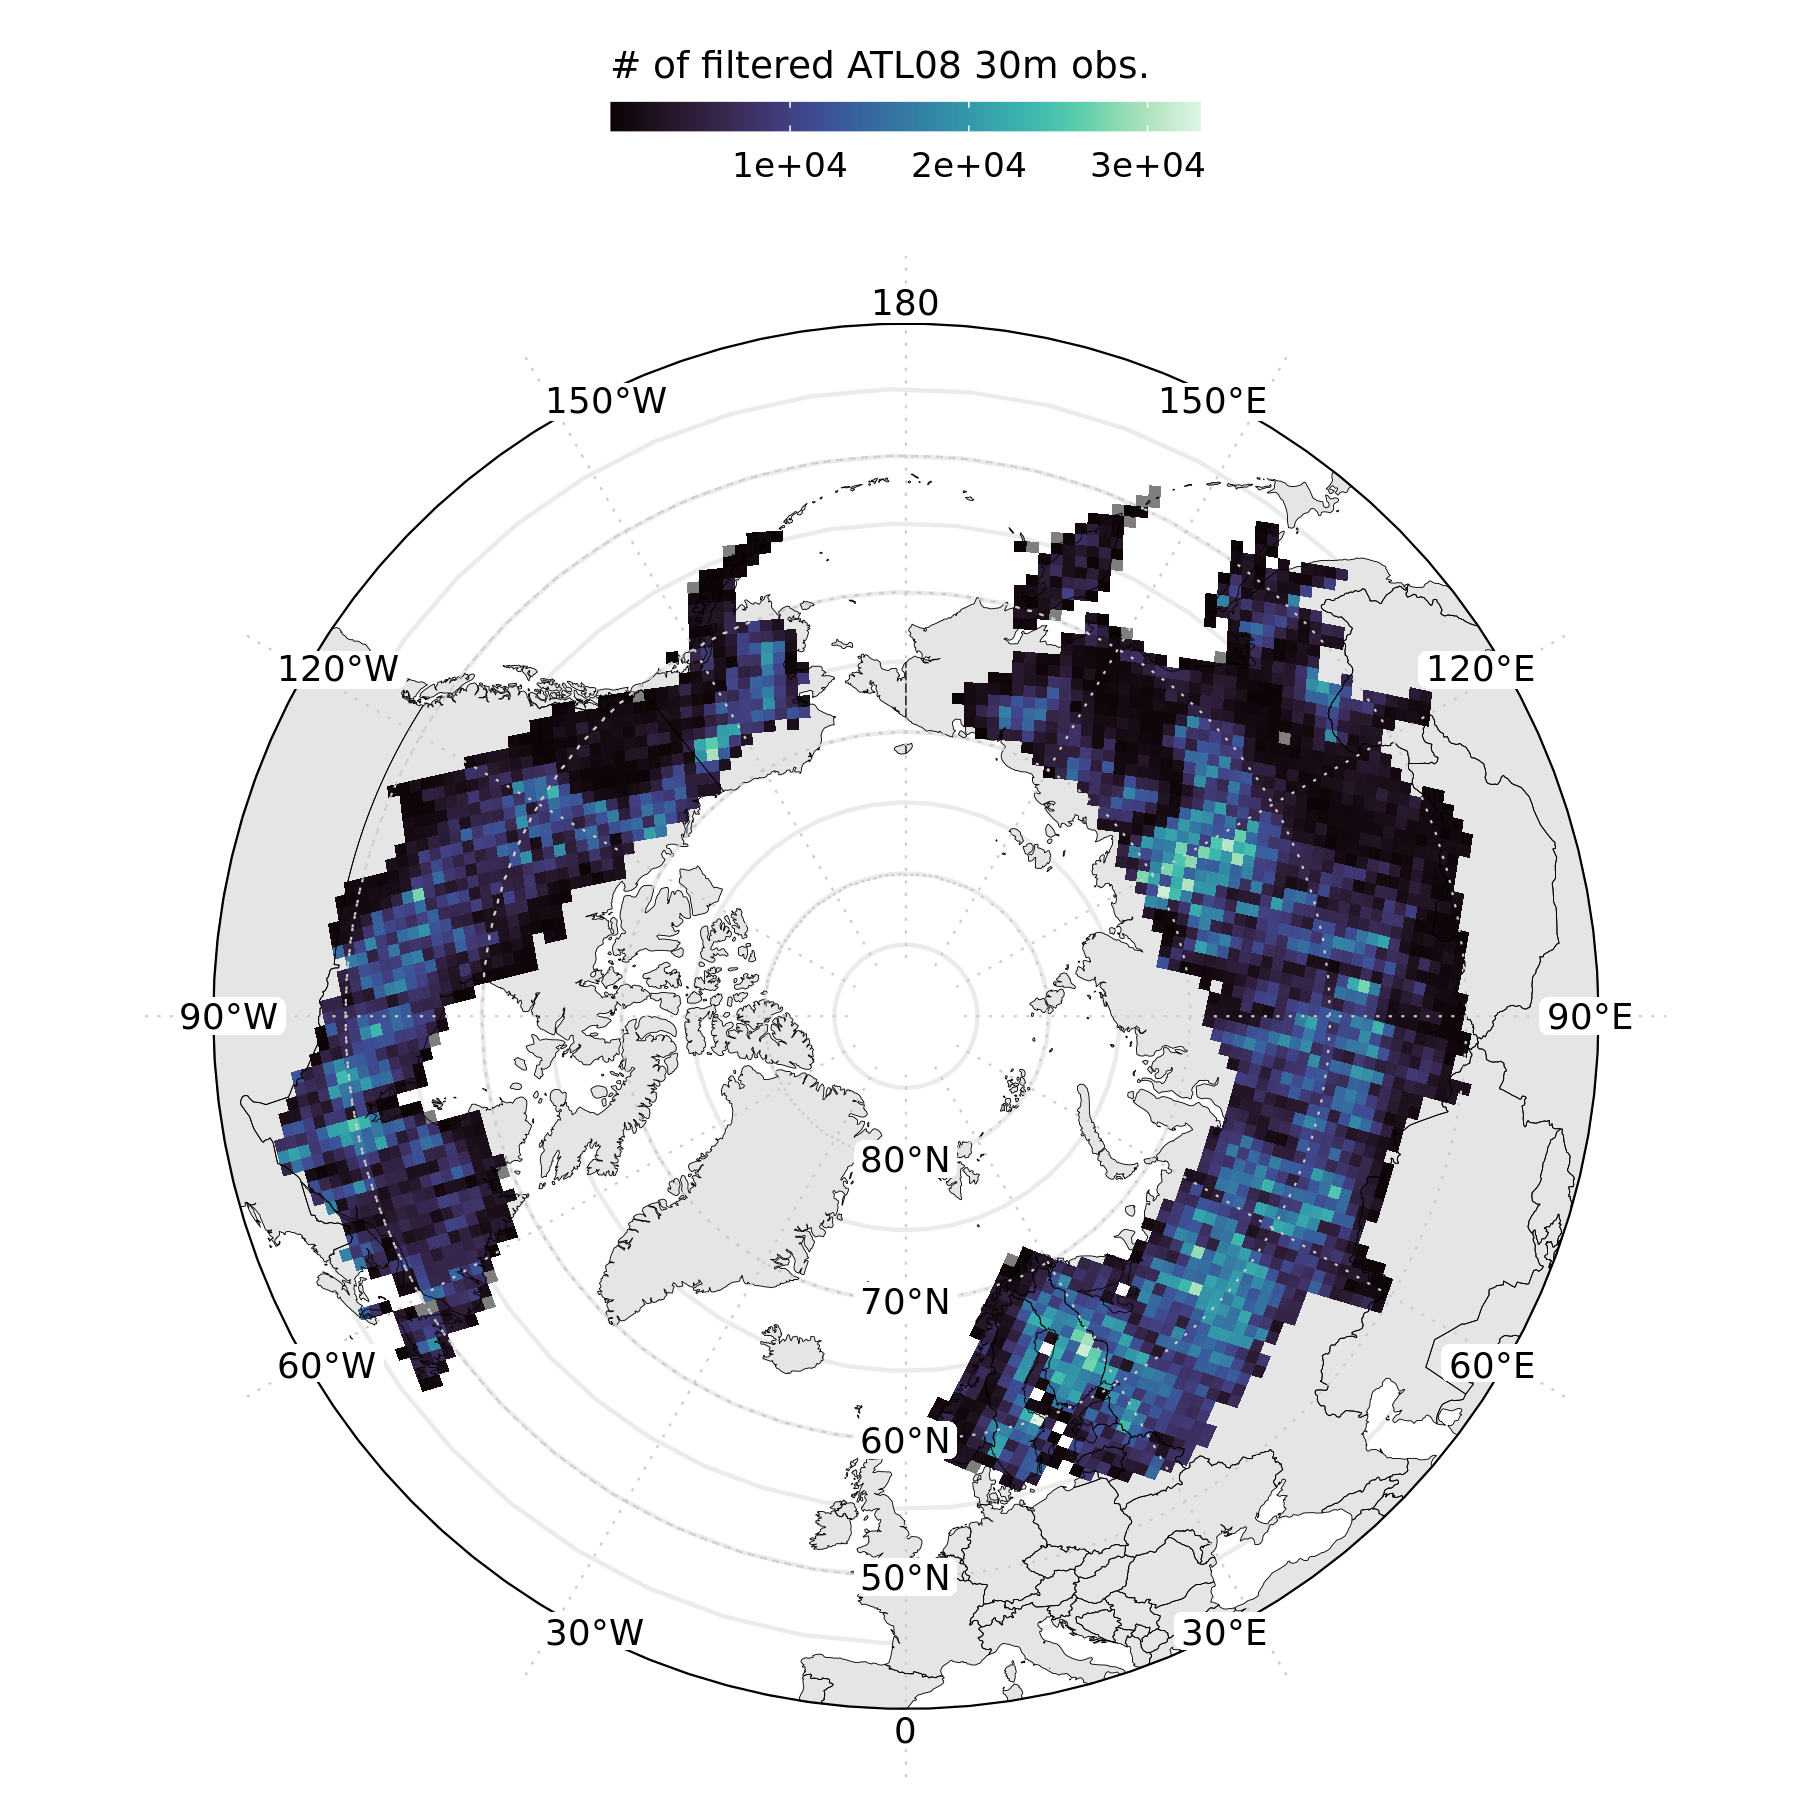

In [11]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)
# Show map of HLS compositing params

m_ATL08obs_tile = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     boreal_shp_fn = boreal_shp_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_gcs_ATL08obs %>% dplyr::filter(tile_num %in% boreal_tile_num_list), 
                                                    aes(x = long, y = lat, group = group, fill=n_obs), size=0.1)
                                      )
                    ) + 
    theme(legend.text=element_text(size=rel(0.75))) +
    guides(fill=guide_colourbar(title="# of filtered ATL08 30m obs.", title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))+
    scale_fill_viridis(option = 'mako', labels = scientific)

m_ATL08obs_tile

## Export figure: ATL08 obs count

In [379]:
DATA_NAME_STEM = "ATL08_obs_tile"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", var_ht, EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_ATL08obs_tile,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 6, height = 6)
}

/projects/my-public-bucket/boreal_polar_map/paper_figs/map_ATL08_obs_tile_h_can_20230207.png
/projects/my-public-bucket/boreal_polar_map/paper_figs/map_ATL08_obs_tile_h_can_20230207.pdf


### Get boreal ATL08 tiles
Read ATL08, filter ATL08 file list CSV by boreal tile nums

In [12]:
print(dim(Atl08_filt))
files_boreal = Atl08_filt %>% dplyr::filter(tile_num %in% boreal_tile_num_list)
print(dim(files_boreal))
head(files_boreal)

[1] 4880    6
[1] 2991    6


,Unnamed..0,s3_path,local_path,file,tile_num,n_obs
,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,34,s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/12/01/13/59/41/965091/atl08_005_30m_filt_topo_landsat_20221201_1920.csv,/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/12/01/13/59/41/965091/atl08_005_30m_filt_topo_landsat_20221201_1920.csv,atl08_005_30m_filt_topo_landsat_20221201_1920.csv,1920,739
2,22,s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/12/01/13/46/39/030721/atl08_005_30m_filt_topo_landsat_20221201_3456.csv,/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/12/01/13/46/39/030721/atl08_005_30m_filt_topo_landsat_20221201_3456.csv,atl08_005_30m_filt_topo_landsat_20221201_3456.csv,3456,9314
3,18,s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/12/01/13/45/56/388940/atl08_005_30m_filt_topo_landsat_20221201_3382.csv,/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/12/01/13/45/56/388940/atl08_005_30m_filt_topo_landsat_20221201_3382.csv,atl08_005_30m_filt_topo_landsat_20221201_3382.csv,3382,1221
4,9740,s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/11/30/23/59/49/099732/atl08_005_30m_filt_topo_landsat_20221130_3109.csv,/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/11/30/23/59/49/099732/atl08_005_30m_filt_topo_landsat_20221130_3109.csv,atl08_005_30m_filt_topo_landsat_20221130_3109.csv,3109,4608
5,9734,s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/11/30/23/58/45/703343/atl08_005_30m_filt_topo_landsat_20221130_27382.csv,/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/11/30/23/58/45/703343/atl08_005_30m_filt_topo_landsat_20221130_27382.csv,atl08_005_30m_filt_topo_landsat_20221130_27382.csv,27382,7135
6,9722,s3://maap-ops-workspace/lduncanson/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/11/30/23/58/23/178851/atl08_005_30m_filt_topo_landsat_20221130_27646.csv,/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/11/30/23/58/23/178851/atl08_005_30m_filt_topo_landsat_20221130_27646.csv,atl08_005_30m_filt_topo_landsat_20221130_27646.csv,27646,14784


# Read ATL08 obs (filtered) and APPLY AGB model
#### `Filtered`: Read in our set of ATL08 filt CSV tiles (where the tiles have been clipped to the boreal domain), and clip the observations to the boreal domain  
For boreal tiles

In [13]:
s3read_and_get_tilenum <- function(x){
    # Read table and make column with tile_num
    df = aws.s3::s3read_using(fread, object = x)
    # Use filename to get tile
    fn_stem = tools::file_path_sans_ext(x)
    list_fn_stem = strsplit(basename(fn_stem), '_')[[1]]
    tile_num = list_fn_stem[length(list_fn_stem)] #<- tile num in filename is in the last position of the list
    #print(tile_num)
    df$tile_num = tile_num
    return(df)
}

## Calc AGB for ATL08 obs clipped to boreal extent

In [14]:
atl08_feather_fn = '/projects/my-public-bucket/boreal_polar_map/tables/atl08_all_boreal_tiles.feather'

ATL08_cols_list = c("tile_num", "seg_landcov", "lon","lat","rh25","rh50","rh60","rh70","rh75","rh80","rh90","h_can")#,"rh95","rh98")
ATL08_NAMES_FOR_RDS = c("tile_num", "seg_landcov", "lon","lat","RH_25","RH_50","RH_60","RH_70","RH_75","RH_80","RH_90","RH_98", "REALM")

# rds models
models_list <- list.files("/projects/code/icesat2_boreal/notebooks/biomass_models", ".rds", full.names = T)

# adding model ids
models_id_list <- names(models_list) <- paste0("m",1:length(models_list))

In [15]:
# atl08_test = st_intersection(st_as_sf(
#                                 do.call(rbind, lapply(
#                                     #files_boreal$s3_path, 
#                                     head(files_boreal, 10)$s3_path, #<-- for testing
#                                     function(x) s3read_and_get_tilenum(x)
#                                         )
#                                        ) %>% dplyr::select(ATL08_cols_list),
#                                 coords = c('lon', 'lat') , 
#                                 remove = FALSE,
#                                 crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
#                                     ), 
#                         boreal %>% dplyr::select(REALM)# intersect ATL08 with boreal extent
#                         #boreal_tiles_clip # intersect ATL08 with boreal tiles extent
#                         ) %>%
#                         as.data.frame() %>%
#                         dplyr::select(ATL08_cols_list, REALM)
                                    
    
# # Calculate AGB_mean and AGB_se for each ATL08 obs
# names(atl08_test) = ATL08_NAMES_FOR_RDS
# atl08_test = GEDI2AT08AGB_v2(models_list, models_id_list, atl08_test , COLS_LIST = ATL08_NAMES_FOR_RDS, RESAMP_COVAR_MAT=TRUE, RESAMP_ITER=2)

# # https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global#bands
# class_values = c( 0, 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 30, 90, 100, 60, 40, 50, 70, 80, 200)
# class_names = c('No data','Closed forest\nevergreen needle','Closed forest\ndeciduous needle','Closed forest\nevergreen_broad','Closed forest\ndeciduous broad','Closed forest\nmixed', 'Closed forest\nunknown','Open forest\nevergreen needle',
#                 'Open forest\ndeciduous needle','Open forest\nevergreen_broad','Open forest\ndeciduous_broad','Open forest\nmixed', 'Open forest\nunknown', 'Shrubs','Herbaceous', 'Herbaceous\nwetleand','Moss/lichen', 'Bare/sparse','Cultivated/managed',
#                 'Urban/built', 'Snow/ice','Permanent\nwater', 'Open sea')
# class_colors = c('#282828','#FFBB22','#FFFF4C','#F096FF','#FA0000','#B4B4B4','#F0F0F0','#0032C8','#0096A0','#FAE6A0','#58481F','#009900',
#                 '#70663E','#00CC00','#4E751F','#007800','#666000','#8DB400','#8D7400','#A0DC00','#929900','#648C00','#000080')

# atl08_test$seg_landcov = factor(atl08_test$seg_landcov, levels=class_values , labels=class_names)

# tail(atl08_test)

In [ ]:
if(TRUE){
    
#     atl08 = do.call(rbind, lapply(
#                 files_boreal$s3_path, 
#                 #head(files_boreal, 100)$s3_path), #<-- for testing
#                 function(x) s3read_and_get_tilenum(x)
#                 )) %>% dplyr::select(ATL08_cols_list)
    
    atl08 = st_intersection(st_as_sf(
                                do.call(rbind, lapply(
                                    files_boreal$s3_path, 
                                    #head(files_boreal, 10)$s3_path, #<-- for testing
                                    function(x) s3read_and_get_tilenum(x)
                                        )
                                       ) %>% dplyr::select(ATL08_cols_list),
                                coords = c('lon', 'lat') , 
                                remove = FALSE,
                                crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
                                    ), 
                        boreal %>% dplyr::select(REALM)# intersect ATL08 with boreal extent
                        #boreal_tiles_clip # intersect ATL08 with boreal tiles extent
                        ) %>%
                        as.data.frame() %>%
                        dplyr::select(ATL08_cols_list, REALM)
    
    # Calculate AGB_mean and AGB_se for each ATL08 obs
    names(atl08) = ATL08_NAMES_FOR_RDS
    atl08 = GEDI2AT08AGB_v2(models_list, models_id_list, atl08 , COLS_LIST = ATL08_NAMES_FOR_RDS, RESAMP_COVAR_MAT=TRUE, RESAMP_ITER=2)

    # https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global#bands
    class_values = c( 0, 111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20, 30, 90, 100, 60, 40, 50, 70, 80, 200)
    class_names = c('No data','Closed forest\nevergreen needle','Closed forest\ndeciduous needle','Closed forest\nevergreen_broad','Closed forest\ndeciduous broad','Closed forest\nmixed', 'Closed forest\nunknown','Open forest\nevergreen needle',
                    'Open forest\ndeciduous needle','Open forest\nevergreen_broad','Open forest\ndeciduous_broad','Open forest\nmixed', 'Open forest\nunknown', 'Shrubs','Herbaceous', 'Herbaceous\nwetleand','Moss/lichen', 'Bare/sparse','Cultivated/managed',
                    'Urban/built', 'Snow/ice','Permanent\nwater', 'Open sea')
    class_colors = c('#282828','#FFBB22','#FFFF4C','#F096FF','#FA0000','#B4B4B4','#F0F0F0','#0032C8','#0096A0','#FAE6A0','#58481F','#009900',
                    '#70663E','#00CC00','#4E751F','#007800','#666000','#8DB400','#8D7400','#A0DC00','#929900','#648C00','#000080')

    atl08$seg_landcov = factor(atl08$seg_landcov, levels=class_values , labels=class_names)
    
    # Write a new feather dataset of boreal-filtered ATL08 RH metrics, AGB_mean, & AGB_se for all boreal tiles 
    write_feather(atl08, path = atl08_feather_fn)
    
}else{
    atl08 = read_feather(atl08_feather_fn)
}
#print(paste0('Total filtered ATL08 obs for ', dim(files_boreal)[1],' tiles of boreal domain: ', dim(atl08)[1]))
print(paste0('Total filtered ATL08 obs for with AGB in boreal domain: ', dim(atl08)[1]))

head(atl08)

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(ATL08_cols_list)` instead of `ATL08_cols_list` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [ ]:
options(repr.plot.width = 25, repr.plot.height = 7, repr.plot.res = 100)

hist_agbmean = atl08 %>% 
    ggplot() + 
    geom_histogram(aes(x=AGB_mean_mg_ha, fill=..x..), binwidth=5 )+
    scale_fill_gradientn(limits = c(0, MAX_AGB), breaks = seq(0, MAX_AGB, 25), colours = c(viridis::viridis(10)) , oob=squish, name='Mg/ha') +
    #scale_fill_viridis() +
    coord_cartesian(xlim=c(0,300)) +
    theme_bw()+
    facet_wrap(~REALM, ncol=1)

hist_agbse = atl08 %>% 
    ggplot() +  
    geom_bar(aes(y=as.numeric(AGB_se_mg_ha), x=factor(AGB_model_id), fill=factor(AGB_model_id)) , stat="identity")+
    #scale_fill_gradientn(limits = c(0, 5), breaks = seq(0, 5, 0.5) , colours = c(viridis::plasma(10)) , oob=squish, name='Mg/ha') +
    #scale_fill_viridis() +
    coord_cartesian(xlim=c(0,5)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle=45))+
    facet_wrap(~REALM, ncol=1)
    #facet_wrap(.~AGB_model_id, ncol=3, scales='free_x') 

hist_landcov = atl08 %>% 
    ggplot() +  
    geom_bar(aes(x=factor(seg_landcov), fill=factor(seg_landcov)))+
    #scale_fill_gradientn(limits = c(0, 5), breaks = seq(0, 5, 0.5) , colours = c(viridis::plasma(10)) , oob=squish, name='Mg/ha') +
    #scale_fill_manual(values= colorRampPalette(brewer.pal(8, "Dark2"))(15), name='Boreal AGB\nmodel group') +
    scale_fill_manual(values= class_colors, name='Copernicus\nLand Cover') +
    #coord_cartesian(xlim=c(0,5)) +
    theme_bw() + theme(axis.text.x = element_text(angle=90)) +
    facet_wrap(.~AGB_model_id, ncol=3, scales='free_x') +
    facet_wrap(~REALM, ncol=1)+
    labs(x=NULL)
                         
layout = "
ABC
"

hist_agbmean + hist_agbse + hist_landcov +
    plot_layout(design = layout) +
    plot_annotation(tag_levels = 'a') #+ theme(plot.tag = element_text(size = 26))


In [ ]:
dim(sample_frac(atl08,1e-2))

In [ ]:
min_lat = 45
if(FALSE){
    atl08 = st_intersection(st_as_sf(
                                    sample_frac(
                                                atl08 %>% dplyr::select(tile_num, lon, lat, RH_98, AGB) %>% dplyr::filter(lat > min_lat),
                                                1
                                                ),
                                    coords = c('lon', 'lat') , 
                                    remove = FALSE,
                                    crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"), 
                            boreal # intersect ATL08 with boreal extent
                            #boreal_tiles_clip # intersect ATL08 with boreal tiles extent
                                    ) %>%
                            as.data.frame() %>%
                            dplyr::select(tile_num,lon,lat,RH_98,AGB,REALM)
    #atl08_sf = as(cbind(atl08_sf, st_coordinates(atl08_sf)), 'Spatial') 
    }

In [ ]:
dim(atl08)

## Plot filtered ATL08 30m obs across boreal tiles domain
set up the plotting variables

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)


pal_ht = c('black','#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850')
min_lat = 45
year_atl08 = '2019-2021'

# if(TRUE){
#     df = atl08_sf %>% 
#         as.data.frame() %>%
#         #dplyr::filter(Y > min_lat, night_flg==1)
#         dplyr::filter(Y > min_lat) # We use solar elev < 5
# }else{
#     df = atl08 %>%
#         dplyr::filter(lat > min_lat) 
# }

NUM_ATL08_OBS = prettyNum(dim(atl08)[1],big.mark=",",scientific=FALSE)

# # FRACTION
# df = sample_frac(df, 0.01)


#NUM_ATL08_NIGHT_OBS = prettyNum(dim(atl08 %>% as.data.frame() %>% filter(night_flg==1))[1],big.mark=",",scientific=FALSE)

theme_and_labs = list(
    theme_classic(),
    theme(plot.subtitle=element_text(size=8, hjust=0.5, face="italic", color="black")),
    labs(
        #title="Vegetation canopy heights",
        #subtitle = paste0("Filtered sample of ICESat-2 ATL08 30m observations of RH98 in the boreal forest"," for ",year_atl08),
         #caption = paste0("# obs: ", NUM_ATL08_OBS, "\n# obs (night): ", NUM_ATL08_NIGHT_OBS)
         caption = paste0("# of filtered ICESat-2 ATL08 30m segment obs. in the boreal domain from ", year_atl08,": ", NUM_ATL08_OBS)
    )    
)
scale_color_h_can = scale_colour_gradientn( breaks=c(0,5,10,15, 20, 25), limits = c(0,25), colours=pal_ht, oob=squish)


var_ht = 'RH_98'

map_height_layer_list = list(
    geom_point(data = sample_frac(atl08, 0.01) %>% filter(lat > min_lat), 
               aes_string(x = "lon", y = "lat", colour=var_ht), alpha=0.5, size = 0.00001),
    scale_color_h_can,
    theme_and_labs,
    guides(color=guide_colourbar(title="Vegetation canopy height, max. [m]", title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))
  )
m_ATL08_obs = DO_MAP_BOREAL_SP(MAP_EXTENT=extent(-180,180,min_lat,90), boreal_shp_fn = boreal_shp_fn, LAYER_LIST = map_height_layer_list)
m_ATL08_obs

## Export figure: ATL08 obs

In [ ]:
DATA_NAME_STEM = "ATL08_obs_filt_boreal_clip"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", var_ht, EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_ATL08_obs,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 6, height = 6)
}

In [ ]:
#writeOGR(atl08, path(out_dir, paste0(DATA_NAME_STEM,"_", EXPORT_TIME_STR), layer=DATA_NAME_STEM, driver="GeoJSON")
st_write(atl08, path(out_dir, paste0(DATA_NAME_STEM,"_", EXPORT_TIME_STR, ".gpkg"), DATA_NAME_STEM)

## Plot ATL08 AGB obs

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 300)


MAX_AGB = 100
min_lat = 45
year_atl08 = '2019-2021'


NUM_ATL08_OBS = prettyNum(dim(atl08)[1],big.mark=",",scientific=FALSE)



#NUM_ATL08_NIGHT_OBS = prettyNum(dim(atl08 %>% as.data.frame() %>% filter(night_flg==1))[1],big.mark=",",scientific=FALSE)

theme_and_labs = list(
    theme_classic(),
    theme(plot.subtitle=element_text(size=8, hjust=0.5, face="italic", color="black")),
    labs(
        #title="Vegetation canopy heights",
        #subtitle = paste0("Filtered sample of ICESat-2 ATL08 30m observations of RH98 in the boreal forest"," for ",year_atl08),
         #caption = paste0("# obs: ", NUM_ATL08_OBS, "\n# obs (night): ", NUM_ATL08_NIGHT_OBS)
         #caption = paste0("# of ICESat-2 ATL08 30m segment AGB training obs. from ", year_atl08,": ", NUM_ATL08_TRAINOBS)
    )    
)


var_ht = "AGB_mean_mg_ha"

map_AGB_layer_list = list(
    geom_point(data = sample_frac(atl08, 0.01) %>% filter(lat > min_lat), aes_string(x = "lon", y = "lat", colour=var_ht), alpha=0.5, size = 0.00001),
    scale_color_gradientn(limits = c(0,MAX_AGB), breaks = seq(0,MAX_AGB,25), colours = viridis(10), , oob=squish ),
    theme_and_labs,
    guides(color=guide_colourbar(title=expression("Mean of aboveground biomass density ["~Mg~ha^{-1}~"]"), title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))
  )
m_AGBtrain_obs = DO_MAP_BOREAL_SP(MAP_EXTENT=extent(-180,180,min_lat,90), boreal_shp_fn = boreal_shp_fn, LAYER_LIST = map_AGB_layer_list)
m_AGBtrain_obs

## Export figure: ATL08 AGB obs

In [ ]:
DATA_NAME_STEM = "ATL08_obs_filt_boreal_clip"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path(OUT_FIGURE_DIR, paste0("map_",DATA_NAME_STEM,"_", var_ht, EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = m_ATL08_obs,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 6, height = 6)
}

## Read the ICESat-2 ATL08 AGB training CSVs

In [49]:
tindex_master$s3_path_train = with(tindex_master, stringi::stri_replace_all_fixed(s3_path, '.tif', "_train_data.csv"))
head(tindex_master)

,X,s3_path,local_path,file,tile_num,s3_path_train
,<int>,<chr>,<chr>,<chr>,<int>,<chr>
1,52,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/05/42/01/342476/boreal_agb_202302151676439579_1326.tif,/projects/my-private-bucket/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/05/42/01/342476/boreal_agb_202302151676439579_1326.tif,boreal_agb_202302151676439579_1326.tif,1326,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/05/42/01/342476/boreal_agb_202302151676439579_1326_train_data.csv
2,51,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/37/27/666751/boreal_agb_202302151676435792_3402.tif,/projects/my-private-bucket/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/37/27/666751/boreal_agb_202302151676435792_3402.tif,boreal_agb_202302151676435792_3402.tif,3402,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/37/27/666751/boreal_agb_202302151676435792_3402_train_data.csv
3,50,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/37/07/664247/boreal_agb_202302151676435665_3417.tif,/projects/my-private-bucket/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/37/07/664247/boreal_agb_202302151676435665_3417.tif,boreal_agb_202302151676435665_3417.tif,3417,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/37/07/664247/boreal_agb_202302151676435665_3417_train_data.csv
4,49,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/16/33/261650/boreal_agb_202302151676434536_3215.tif,/projects/my-private-bucket/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/16/33/261650/boreal_agb_202302151676434536_3215.tif,boreal_agb_202302151676434536_3215.tif,3215,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/16/33/261650/boreal_agb_202302151676434536_3215_train_data.csv
5,48,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/15/13/780147/boreal_agb_202302151676434460_3035.tif,/projects/my-private-bucket/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/15/13/780147/boreal_agb_202302151676434460_3035.tif,boreal_agb_202302151676434460_3035.tif,3035,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/04/15/13/780147/boreal_agb_202302151676434460_3035_train_data.csv
6,47,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/03/50/37/623710/boreal_agb_202302151676432986_2782.tif,/projects/my-private-bucket/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/03/50/37/623710/boreal_agb_202302151676432986_2782.tif,boreal_agb_202302151676432986_2782.tif,2782,s3://maap-ops-workspace/lduncanson/dps_output/run_boreal_biomass_quick_v2_ubuntu/map_boreal_2022_rh_noground_v4/2023/02/15/03/50/37/623710/boreal_agb_202302151676432986_2782_train_data.csv


In [52]:
smry_tile_train = atl08_agb_train %>% 
    dplyr::mutate(tile_num = as.numeric(tile_num)) %>%
    dplyr::group_by(tile_num) %>%
    dplyr::summarize(n_obs = n())
write.csv(smry_tile_train, file = '/projects/my-public-bucket/boreal_polar_map/tables/smry_atl08_agb_train_tiles.csv')
head(smry_tile_train)

tile_num,n_obs
<dbl>,<int>
4,8773
9,8773
10,8773
11,8773
12,8773
13,8773


In [29]:
boreal_tiles_gcs_ATL08obs_AGBtrain = boreal_tiles_gcs %>% 
    dplyr::mutate(tile_num = as.numeric(tile_num)) %>% 
    dplyr::left_join(smry_tile_train, by = c('tile_num' = 'tile_num'))
head(boreal_tiles_gcs_ATL08obs_AGBtrain)

,long,lat,order,hole,piece,id,group,tile_num,tile_version,tile_group,map_version,n_obs
,<dbl>,<dbl>,<int>,<lgl>,<fct>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<int>
1,4.624619,56.64562,1,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA
2,5.390977,57.33162,2,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA
3,6.672362,56.91323,3,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA
4,5.890771,56.23471,4,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA
5,4.624619,56.64562,5,FALSE,1,1,1.1,1,version 1,eurasia west,NA,NA
6,3.329813,57.04317,1,FALSE,1,2,2.1,2,version 1,eurasia west,NA,NA


OGR data source with driver: GeoJSON 
Source: "/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson", layer: "wwf_circumboreal_Dissolve"
with 2 features
It has 4 fields


Regions defined for each Polygons

Regions defined for each Polygons

Regions defined for each Polygons



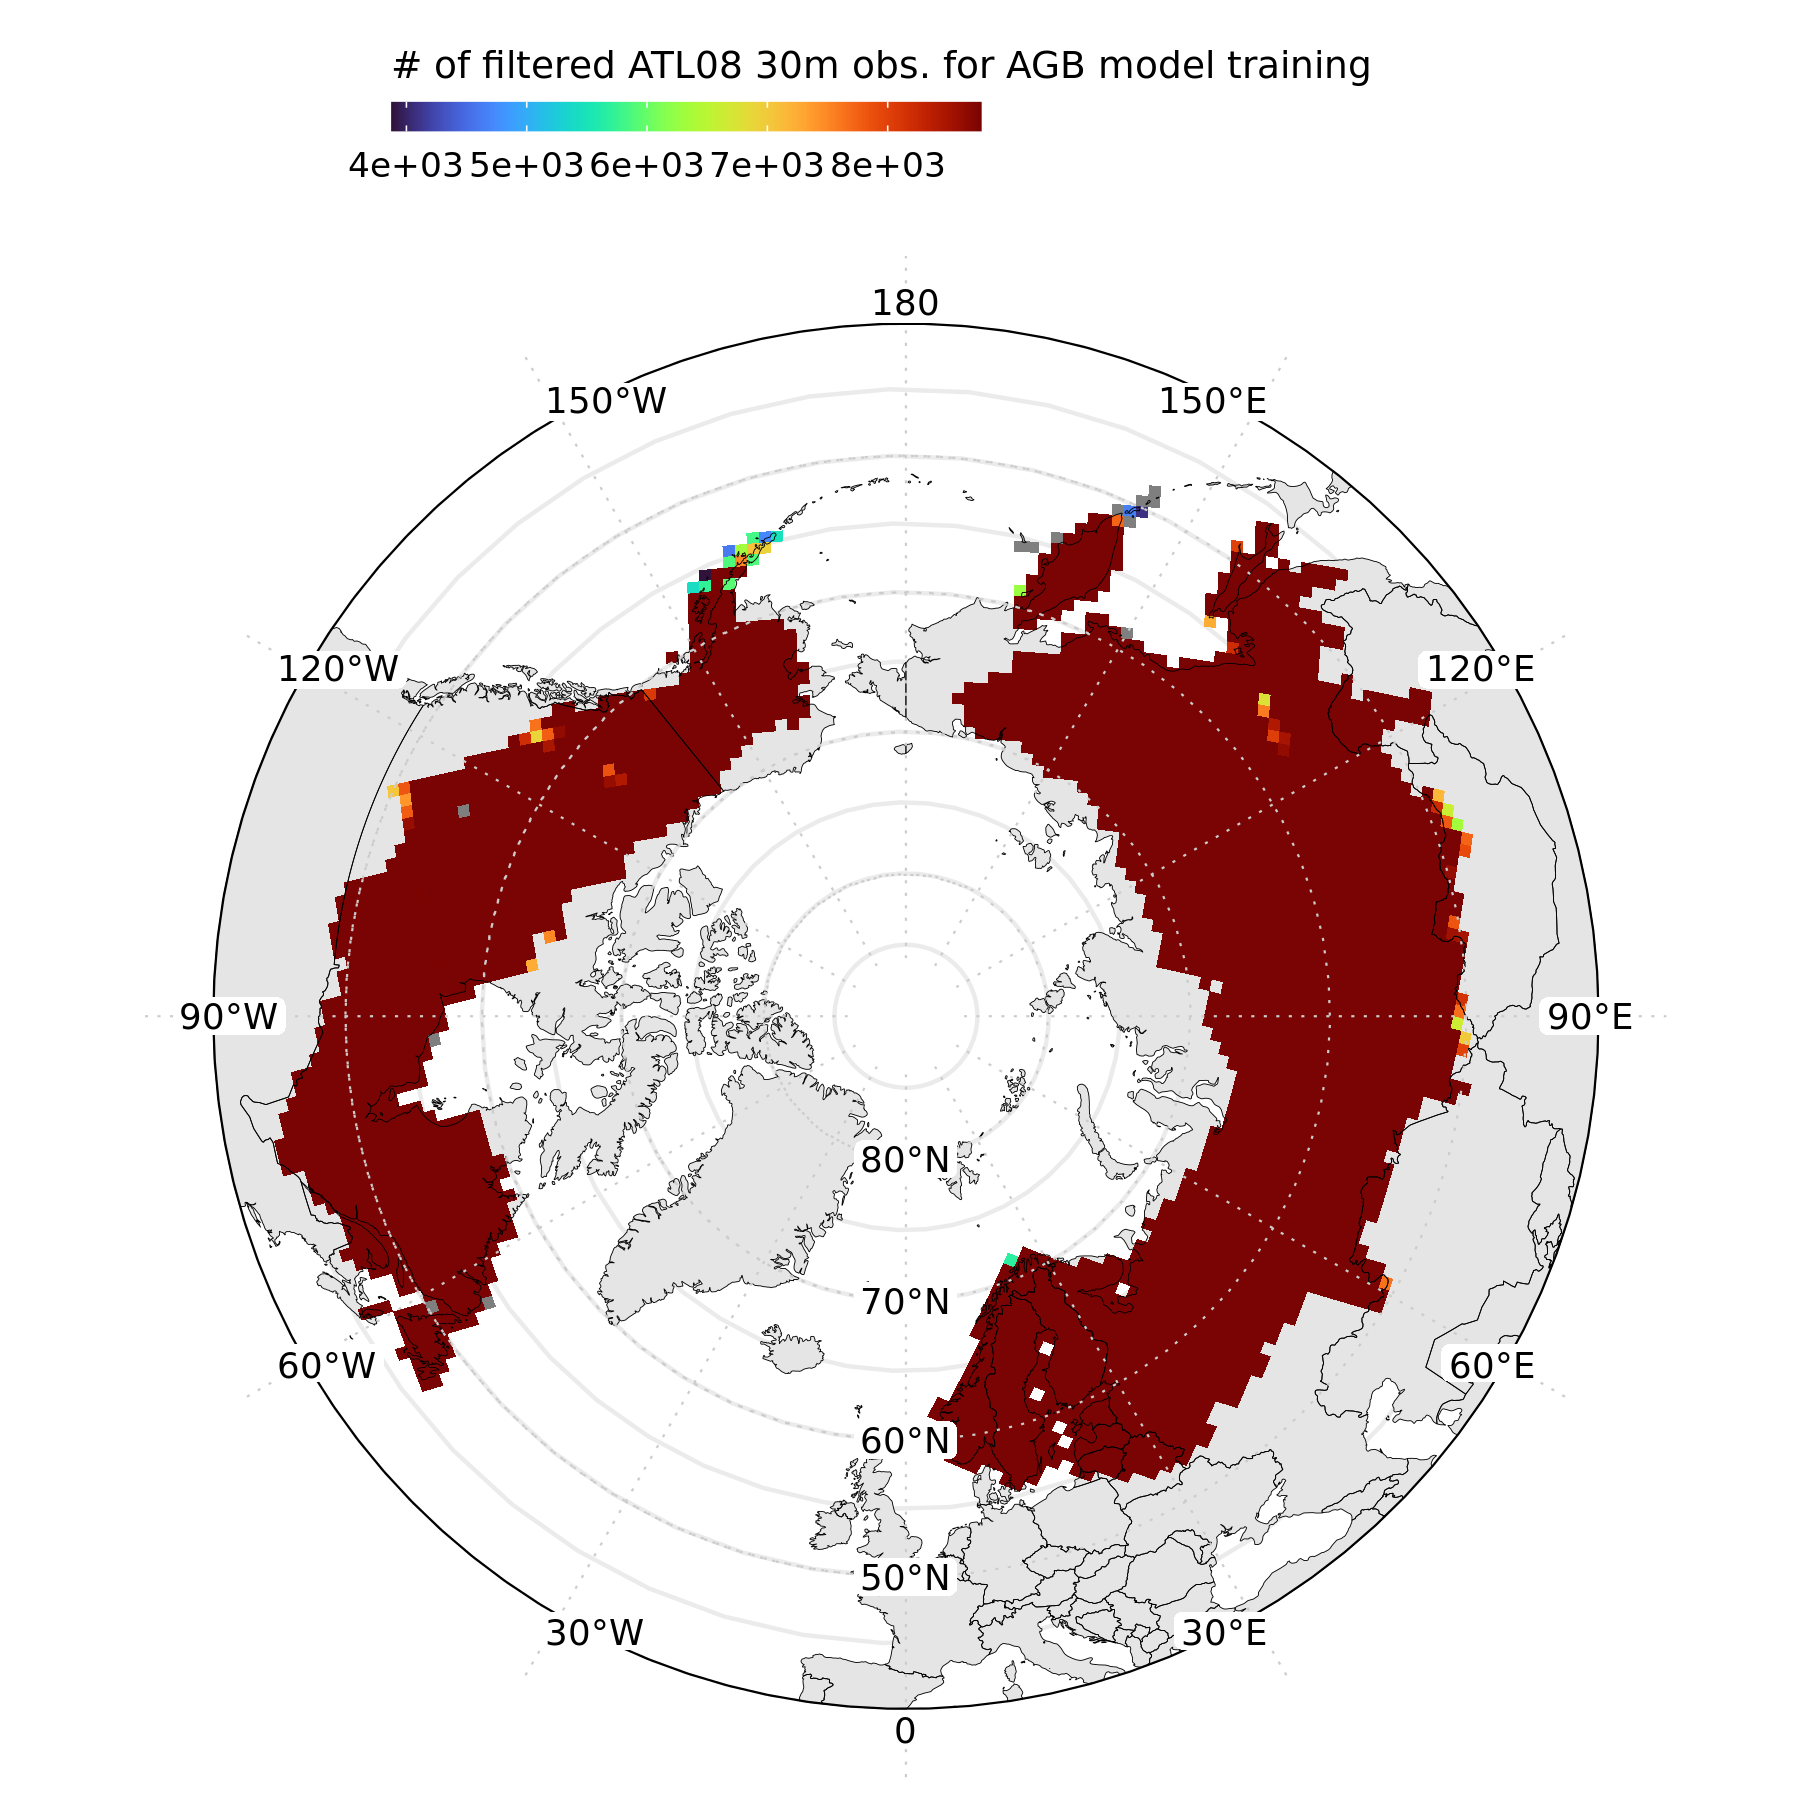

In [30]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 300)
# Show map of HLS compositing params

m_ATL08obs_AGBtrain_tile = DO_MAP_BOREAL_SP(MAP_EXTENT=ext,  
                     boreal_shp_fn = boreal_shp_fn,
                     LAYER_LIST = list(geom_polygon(data = boreal_tiles_gcs_ATL08obs_AGBtrain %>% dplyr::filter(tile_num %in% boreal_tile_num_list), 
                                                    aes(x = long, y = lat, group = group, fill=n_obs), size=0.1)
                                      )
                    ) + 
    theme(legend.text=element_text(size=rel(0.75))) +
    guides(fill=guide_colourbar(title="# of filtered ATL08 30m obs. for AGB model training", title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))+
    scale_fill_viridis(option = 'turbo', labels = scientific)

m_ATL08obs_AGBtrain_tile